# Import MANO layer

In [1]:
import torch
from manopth.manolayer import ManoLayer
from manopth import demo

from commons import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Use CUDA device if available

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# Initialize the MANO layer

- Hand side: right

In [3]:
# Create a MANO layer with default settings
mano_layer = ManoLayer(
    center_idx=0,
    flat_hand_mean=True,
    ncomps=45,
    side="right",
    mano_root=PROJ_ROOT/ "config/mano_models",
    use_pca=True,
    root_rot_mode="axisang",
    joint_rot_mode="axisang",
    robust_rot=True,
)

# Move the MANO layer to the device
mano_layer = mano_layer.to(device)

c:\Users\Lyndo\miniconda3\envs\summer_camp\lib\site-packages\manopth\manolayer.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))


# Load MANO Shape parameters from file

In [4]:
data = read_data_from_json(PROJ_ROOT / "data/calibration/mano/subject_7/mano.json")
print(f"Load data from json: {data}")

# create a hand pose parameter tensor
shape_params = torch.tensor(data["betas"], dtype=torch.float32).to(device)
print(f"shape_params tensor: {shape_params}")

# add batch dimension
shape_params = shape_params.unsqueeze(0)
print(f"shape_params tensor with batch dim: {shape_params.shape}")

Load data from json: {'betas': [0.5249806046485901, -0.1814141571521759, -1.033352017402649, -0.1214933767914772, 0.6012066006660461, -0.06230009347200394, 0.2206561267375946, -0.2300504893064499, -0.3744576871395111, -0.30397969484329224]}
shape_params tensor: tensor([ 0.5250, -0.1814, -1.0334, -0.1215,  0.6012, -0.0623,  0.2207, -0.2301,
        -0.3745, -0.3040])
shape_params tensor with batch dim: torch.Size([1, 10])


# Load MANO Pose parameters from file

In [5]:
poses_m = np.load(PROJ_ROOT / "data/recordings/20231022_193630/poses_m.npy")
print(f"MANO poses loaded: {poses_m.shape}")    # (hand_num, frame_num, 51), the first 48 are pose parameters, last 3 are global translation

# read frame_id=230 for right hand (index=0)
pose_m = poses_m[0, 230]
print(f"pose_params: {pose_m}")

# create a hand pose parameter tensor from numpy array
pose_params = torch.tensor(pose_m[:48], dtype=torch.float32).to(device)
print(f"pose_params tensor: {pose_params}")

# create a global translation parameter tensor from numpy array
global_trans = torch.tensor(pose_m[48:], dtype=torch.float32).to(device)
print(f"global_trans tensor: {global_trans}")

# add batch dimension
pose_params = pose_params.unsqueeze(0)
print(f"pose_params tensor with batch dim: {pose_params.shape}")
global_trans = global_trans.unsqueeze(0)
print(f"global_trans tensor with batch dim: {global_trans.shape}")

MANO poses loaded: (2, 790, 51)
pose_params: [ 1.4993439  -0.06881595 -1.05807    -1.0385576   0.04918966 -0.867342
 -1.2200967  -0.13270132 -0.22133271 -0.25494617  0.42836088 -0.60679185
  0.12153926 -0.57773596  0.00834388  0.18348242 -0.1729043   0.07530318
  0.14874037  0.14394674 -0.8210136   0.09075375  0.6042777   0.09556013
 -0.01027771  0.05393587  0.09491615 -0.6044765   0.21281272  0.30204523
  0.3741042   0.0358454   0.33586493  0.02978444 -0.22448471 -0.11035845
  0.01161458 -0.07594452 -0.19956134  0.24496993  0.08856282 -0.03697837
  0.23955911 -0.0184443   0.2630349   0.04583528  0.14956667 -0.0370829
 -0.09651808 -0.19009547  0.11650179]
pose_params tensor: tensor([ 1.4993, -0.0688, -1.0581, -1.0386,  0.0492, -0.8673, -1.2201, -0.1327,
        -0.2213, -0.2549,  0.4284, -0.6068,  0.1215, -0.5777,  0.0083,  0.1835,
        -0.1729,  0.0753,  0.1487,  0.1439, -0.8210,  0.0908,  0.6043,  0.0956,
        -0.0103,  0.0539,  0.0949, -0.6045,  0.2128,  0.3020,  0.3741,  0.03

In [6]:
hand_verts, hand_joints = mano_layer(pose_params, shape_params, global_trans)
hand_faces = mano_layer.th_faces
# Convert to meters
hand_verts = hand_verts / 1000.0
hand_joints = hand_joints / 1000.0

# Convert the resulting vertices, joints and faces to numpy
hand_verts_np = hand_verts[0].cpu().detach().numpy()
hand_joints_np = hand_joints[0].cpu().detach().numpy()
hand_faces_np = hand_faces.cpu().detach().numpy()

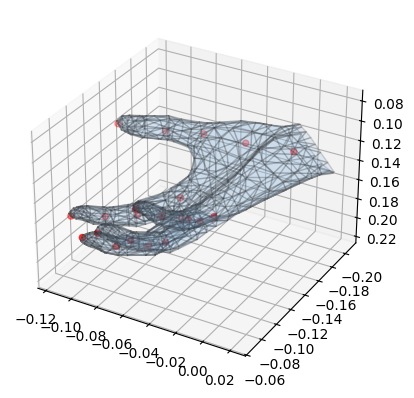

In [7]:
demo.display_hand(
    {
        'verts': hand_verts,
        'joints': hand_joints
    },
    mano_faces=hand_faces,
)

In [8]:
# Visualize the hand
# Create a triangle mesh from the vertices and faces
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(hand_verts_np)
mesh.triangles = o3d.utility.Vector3iVector(hand_faces_np)

# Estimate normals
mesh.compute_vertex_normals()
mesh.normalize_normals()

# Paint the mesh a uniform grey color
mesh.paint_uniform_color([0.3, 0.3, 0.3])

# Joints as red spheres
joint_mesh = o3d.geometry.TriangleMesh()
for joint in hand_joints_np:
    joint_mesh += o3d.geometry.TriangleMesh.create_sphere(radius=0.003).translate(joint)
joint_mesh.paint_uniform_color([1, 0, 0])

# Visualize the mesh
o3d.visualization.draw([mesh, joint_mesh])

[Open3D INFO] Window window_0 created.
[Open3D INFO] ICE servers: {"stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"}
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC Jupyter handshake mode enabled.


: 